In [1]:
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
from tensorflow.keras import regularizers
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
import re
import string

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


# Building Classic Machine Learning Algorithms and Selecting Best One 

In [2]:
data_4 = pd.read_csv('../input/6-cat-data/third.csv')

In [3]:
col = ['Category', 'Content']
df = data_4[col]

In [4]:
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

In [9]:
df = df.drop(2126)

In [11]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Content).toarray()
labels = df.category_id
features.shape

(2126, 52707)

In [13]:
def model_selection(features,labels):
    models = [
        RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
        LinearSVC(),
        MultinomialNB(),
        LogisticRegression(random_state=0),KNeighborsClassifier(n_neighbors=5)
    ]
    CV = 5
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        accuracy = cross_val_score(model, features, labels, scoring='accuracy', cv=CV).mean()
        entries.append((model_name,accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name','accuracy'])
    scores = []
    for i in entries:
        scores.append(i[1])
    best = max(scores)
    for i in entries:
        if i[1]==best:
            print("Best model is "+str(i[0])+" with "+str(best))
            
    return cv_df
    
        

In [14]:
model_selection(features,labels)
    

Best model is LinearSVC with 0.7868975421154377


,model_name,accuracy
0,RandomForestClassifier,0.381476
1,LinearSVC,0.786898
2,MultinomialNB,0.466578
3,LogisticRegression,0.719159
4,KNeighborsClassifier,0.608643


In [15]:
model_SVC = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.20, random_state=42)
model_SVC.fit(X_train, y_train)
y_pred = model_SVC.predict(X_test)

# Building BERT Model 

In [17]:
data = pd.read_csv("../input/6-cat-data/third.csv")
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_stopwords_shortwords(w):
    stopwords_list=stopwords.words('english')
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words) 

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w=clean_stopwords_shortwords(w)
    w=re.sub(r'@\w+', '',w)
    return w

In [18]:
data.Category.unique()

array(['Distribution', 'IT-Services', 'Management-Services',
       'Manufacturing', 'Research', 'Services', nan], dtype=object)

In [24]:
data = data.drop(2126)

In [26]:
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [27]:
max_len=250
sentences=data['text']
labels=data['gt']
len(sentences),len(labels)

(2126, 2126)

In [28]:
def create_model():
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    dbert_layer = dbert_model(inps, attention_mask=masks)[0][:,0,:]
    #kernel_regularizer=regularizers.l2(0.01)
    dense = Dense(250,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dbert_layer)
    dropout= Dropout(0.5)(dense)
    pred = Dense(num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    print(model.summary())
    return model

In [29]:
model22=create_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 250)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 250)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_distil_bert_model[0][0]   

In [30]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])
    
input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [31]:
print('Preparing the pickle file.....')

pickle_inp_path='../dbert_inp.pkl'
pickle_mask_path='./dbert_mask.pkl'
pickle_label_path='./dbert_label.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)

Preparing the pickle file.....
Pickle files saved as  ../dbert_inp.pkl ./dbert_mask.pkl ./dbert_label.pkl


In [32]:
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))

Loading the saved pickle files..
Input shape (2126, 250) Attention mask shape (2126, 250) Input label shape (2126,)


In [33]:
label_class_dict={0:'Services',1:'Manufacturing',2:'Distribution',3:'Research',4:'IT-Services',5:'Management-Services'}
target_names=label_class_dict.values()

In [34]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2,random_state = 42)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.
      format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))


log_dir='dbert_model_6_cat'
model_save_path='./dbert_model_6_cat.h5'



loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model22.compile(loss=loss,optimizer=optimizer, metrics=[metric])

Train inp shape (1700, 250) Val input shape (426, 250)
Train label shape (1700,) Val label shape (426,)
Train attention mask shape (1700, 250) Val attention mask shape (426, 250)


In [35]:
callbacks= [tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,mode='max'),tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_accuracy',
                                               mode='max',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]
model22.compile(loss=loss,optimizer=optimizer, metrics=[metric])

In [36]:
history=model22.fit([train_inp,train_mask],train_label,batch_size=16,epochs=20 ,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

Epoch 1/20
107/107 [==============================] - 38s 289ms/step - loss: 5.5050 - accuracy: 0.2731 - val_loss: 4.8632 - val_accuracy: 0.5469
Epoch 2/20
107/107 [==============================] - 29s 267ms/step - loss: 4.7030 - accuracy: 0.5982 - val_loss: 4.5567 - val_accuracy: 0.6221
Epoch 3/20
107/107 [==============================] - 29s 267ms/step - loss: 4.2620 - accuracy: 0.7278 - val_loss: 4.3189 - val_accuracy: 0.6901
Epoch 4/20
107/107 [==============================] - 29s 267ms/step - loss: 3.9447 - accuracy: 0.8260 - val_loss: 4.2799 - val_accuracy: 0.6995
Epoch 5/20
107/107 [==============================] - 29s 267ms/step - loss: 3.6632 - accuracy: 0.8885 - val_loss: 4.1838 - val_accuracy: 0.7371
Epoch 6/20
107/107 [==============================] - 29s 267ms/step - loss: 3.4057 - accuracy: 0.9416 - val_loss: 4.2741 - val_accuracy: 0.7160
Epoch 7/20
107/107 [==============================] - 29s 268ms/step - loss: 3.2386 - accuracy: 0.9660 - val_loss: 4.3779 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


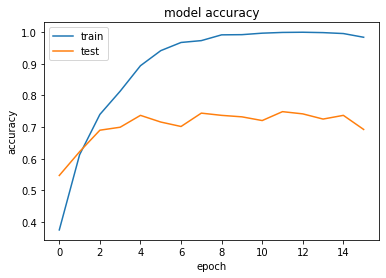

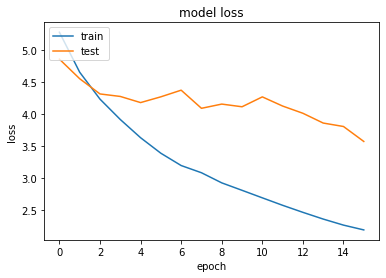

In [37]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
trained_model1 = create_model()
trained_model1.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model1.load_weights(model_save_path)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 250)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 250)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 768)          0           tf_distil_bert_model[1][0] 

# Evaluating BERT and best ML method, Selecting best of ALL

In [42]:
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import matthews_corrcoef

def model_metrics(model):
    
    def multiclass_roc_auc_score(y_test, y_pred):
        lb = preprocessing.LabelBinarizer()
        lb.fit(y_test)
        y_test = lb.transform(y_test)
        y_pred = lb.transform(y_pred)
        return roc_auc_score(y_test, y_pred, multi_class='ovo')
    
    target_names=['Services','Manufacturing','Distribution','Research','IT-Services','Management-Services']
    

    
    if model != trained_model1:
    
        
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        f1 = f1_score(y_test,preds,average = 'weighted')
        confusionmatrix = confusion_matrix(y_test, y_pred)
        accuracy = sum(y_test==preds)/len(y_test)
        print("Accuracy is: "+str(accuracy),"\n")
    
        print("F1 score: "+str(f1),"\n")
        print("ROC_AUC score is : " +str(multiclass_roc_auc_score(y_test, preds)),"\n")
        print("MCC score is : " + str(matthews_corrcoef(y_test,preds)),"\n")
        
        print('Classification Report',"\n")
        print(classification_report(y_test,preds,target_names=target_names),"\n")
        
        fig, ax = plt.subplots(figsize=(8,6))
        sns.heatmap(confusionmatrix, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
        
        return f1,accuracy,multiclass_roc_auc_score(y_test, preds),matthews_corrcoef(y_test,preds)
          
    else:
        preds = trained_model1.predict([val_inp,val_mask],batch_size=16)
        pred_labels = preds.argmax(axis=1)
        f1 = f1_score(val_label,pred_labels,average = 'weighted')
        accuracy = sum(val_label==pred_labels)/len(val_label)
        print("Accuracy is: "+str(accuracy),"\n")
    
        print("F1 score: "+str(f1),"\n")
        confusionmatrix = pd.DataFrame(confusion_matrix(val_label, pred_labels))
        label_class_dict=['Services','Manufacturing','Distribution','Research','IT-Services','Management-Services']
        confusionmatrix["Labels"] = label_class_dict
        confusionmatrix = confusionmatrix.set_index(confusionmatrix["Labels"])
        confusionmatrix = confusionmatrix.rename(columns = {0:'Services',1:'Manufacturing',2:'Distribution',3:'Research',4:'IT-Services',5:'Management-Services'})
        confusionmatrix = confusionmatrix[['Services','Manufacturing','Distribution','Research','IT-Services','Management-Services']]
        print("ROC_AUC score is : " +str(multiclass_roc_auc_score(val_label, pred_labels)),"\n")
        print("MCC score is : " + str(matthews_corrcoef(val_label, pred_labels)),"\n")
        
        evaluation = trained_model1.evaluate([val_inp,val_mask],batch_size=32)
        cross_entropy_loss = evaluation[0]
    
        print("Categorica Crossentropy loss is :"+ str(cross_entropy_loss),"\n")
        
        print('Classification Report',"\n")
        print(classification_report(val_label,pred_labels,target_names=target_names),"\n")

    
        print("Confusion Matrix")
        
        print(confusionmatrix)
    
        return f1,accuracy,multiclass_roc_auc_score(val_label, pred_labels),matthews_corrcoef(val_label, pred_labels)
           

In [43]:
def select_best_model(model1,model2):
    print("######## Results of "+str(model1)+"###########","\n")
    model1_Acc,model1_F1,model1_ROC,model1_MCC = model_metrics(model1)
    print("\n","######## Results of "+str(model2)+"###########","\n")
    model2_Acc,model2_F1,model2_ROC,model2_MCC = model_metrics(model2)
    
    print("####################################################################","\n",
          "#####################################################################","\n")
        
    
    result_model1 = (model1_Acc+model1_F1+model1_ROC+model1_MCC)/4
    result_model2 = (model2_Acc+model2_F1+model2_ROC+model2_MCC)/4
    
    if result_model1>=result_model2:
        best = model1
        score = result_model1
        print("########### Best Model is : "+str(model1)+"###########","\n")
        
    else:
        best = model2
        score = result_model2
        print("########### Best Model is : "+str(model2)+"###########","\n")
        

    print("Average Result of Best Model is "+str(score))

######## Results of <tensorflow.python.keras.engine.functional.Functional object at 0x7fbfeb90a3d0>########### 

Accuracy is: 0.7488262910798122 

F1 score: 0.7431301126570102 

ROC_AUC score is : 0.8276134229550801 

MCC score is : 0.6861819835084745 

14/14 [==============================] - 1s 2ms/step - loss: 2.5172 - accuracy: 0.6925
Categorica Crossentropy loss is :2.5172009468078613 

Classification Report 

                     precision    recall  f1-score   support

           Services       0.72      0.81      0.76       120
      Manufacturing       0.66      0.48      0.56        52
       Distribution       0.72      0.70      0.71        88
           Research       0.73      0.55      0.63        29
        IT-Services       0.88      0.78      0.82        54
Management-Services       0.79      0.93      0.86        83

           accuracy                           0.75       426
          macro avg       0.75      0.71      0.72       426
       weighted avg       0.75

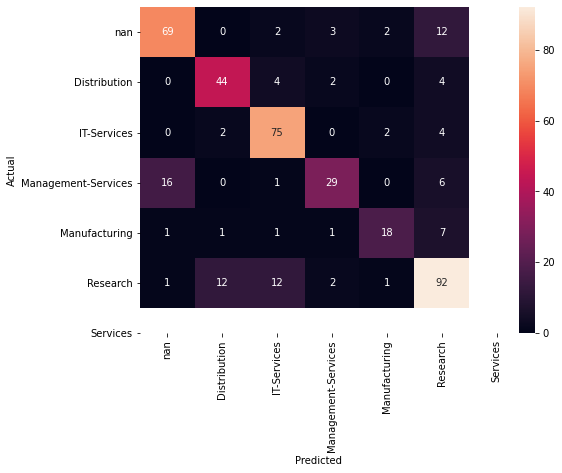

#################################################################### 
 ##################################################################### 

########### Best Model is : LinearSVC()########### 

Average Result of Best Model is 0.7720974525294172


In [44]:
select_best_model(trained_model1,model_SVC)

# Based on results best model is LinearSVC model for 6 category 
